c:\Users\lu050\anaconda3\envs\pytorch\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:12:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


準確率： 0.8418604651162791
                         precision    recall  f1-score   support

          Alain  Prost        1.00      1.00      1.00        10
            Alan Jones        0.67      1.00      0.80         2
       Alberto  Ascari        1.00      1.00      1.00         3
         Ayrton  Senna        1.00      1.00      1.00         8
        Bruce  McLaren        0.00      0.00      0.00         1
     Carlos  Reutemann        0.50      0.50      0.50         2
         Carlos  Sainz        0.00      0.00      0.00         1
      Charles  Leclerc        1.00      1.00      1.00         1
       Clay  Regazzoni        0.00      0.00      0.00         1
           Damon  Hill        1.00      1.00      1.00         4
           Dan  Gurney        0.00      0.00      0.00         1
     Daniel  Ricciardo        0.67      1.00      0.80         2
      David  Coulthard        0.50      0.67      0.57         3
          Denny  Hulme        0.50      0.50      0.50         2


c:\Users\lu050\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lu050\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lu050\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\

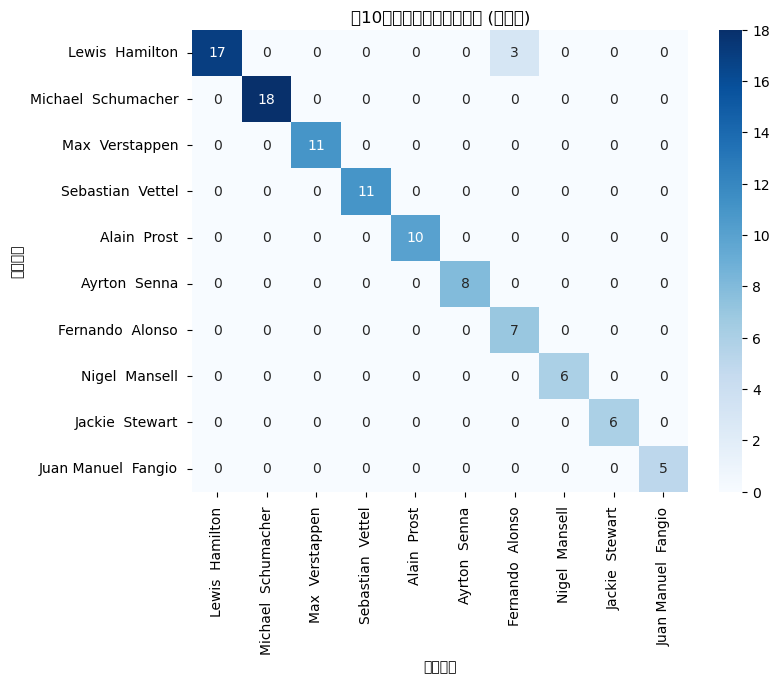


隨機抽選比賽預測結果：
2013 India
Predicted Winner: Sebastian  Vettel  , True Winner: Sebastian  Vettel 

1968 Canada
Predicted Winner: Denny  Hulme  , True Winner: Denny  Hulme 

1984 Great Britain
Predicted Winner: Niki  Lauda  , True Winner: Niki  Lauda 

1992 Hungary
Predicted Winner: Ayrton  Senna  , True Winner: Ayrton  Senna 

2008 Singapore
Predicted Winner: Fernando  Alonso  , True Winner: Fernando  Alonso 

1953 Switzerland
Predicted Winner: Alberto  Ascari  , True Winner: Alberto  Ascari 

2015 Belgium
Predicted Winner: Lewis  Hamilton  , True Winner: Lewis  Hamilton 

2012 Brazil
Predicted Winner: Lewis  Hamilton  , True Winner: Jenson  Button 

2009 Hungary
Predicted Winner: Jenson  Button  , True Winner: Lewis  Hamilton 

1995 San Marino
Predicted Winner: Damon  Hill  , True Winner: Damon  Hill 

1999 Austria
Predicted Winner: Eddie  Irvine  , True Winner: Eddie  Irvine 

1995 Pacific
Predicted Winner: Michael  Schumacher  , True Winner: Michael  Schumacher 

1972 Italy
Predicted W

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# ==== 1. 讀取資料 ====
winners = pd.read_csv('./data/winners.csv')
drivers = pd.read_csv('./data/drivers_updated.csv')
fastest_laps = pd.read_csv('./data/fastest_laps_updated.csv')
teams = pd.read_csv('./data/teams_updated.csv')

# ==== 2. 基本處理 ====
winners['year'] = pd.to_datetime(winners['Date']).dt.year
winners['month'] = pd.to_datetime(winners['Date']).dt.month
fastest_laps['year'] = fastest_laps['year'].astype(int)
drivers['year'] = drivers['year'].astype(int)
teams['year'] = teams['year'].astype(int)

# ==== 3. 合併車手年度數據 ====
df = winners.merge(drivers, left_on=['Winner', 'Car', 'year'], right_on=['Driver', 'Car', 'year'], how='left', suffixes=('', '_driver'))

# ==== 4. 合併最快圈速 ====
df = df.merge(fastest_laps, left_on=['Grand Prix', 'Winner', 'Car', 'year'], right_on=['Grand Prix', 'Driver', 'Car', 'year'], how='left', suffixes=('', '_fastest'))

# ==== 5. 合併車隊年終成績 ====
df = df.merge(teams, left_on=['Car', 'year'], right_on=['Team', 'year'], how='left', suffixes=('', '_team'))

# ==== 6. 特徵工程：最快圈速轉為秒數 ====
def time_to_seconds(time_str):
    try:
        if pd.isna(time_str): return np.nan
        if ':' in time_str:
            m, s = time_str.split(':')
            return int(m)*60 + float(s)
        return float(time_str)
    except:
        return np.nan
df['FastestLapSeconds'] = df['Time_fastest'].apply(time_to_seconds)

# ==== 7. Label Encoding（類別特徵） ====
le_gp = LabelEncoder()
le_car = LabelEncoder()
le_team = LabelEncoder()

df['GPCode'] = le_gp.fit_transform(df['Grand Prix'].astype(str))
df['CarCode'] = le_car.fit_transform(df['Car'].astype(str))
df['TeamCode'] = le_team.fit_transform(df['Team'].astype(str))

# ==== 8. 數值型欄位強制轉型並處理缺失值 ====
num_cols = ['Laps', 'Pos', 'PTS', 'FastestLapSeconds', 'Pos_team', 'PTS_team']
for col in num_cols:
    if col not in df.columns:
        df[col] = np.nan
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].mean())

# ==== 9. 特徵設計 ====
features = [
    'GPCode', 'year', 'month', 'CarCode', 'TeamCode',
    'Laps', 'Pos', 'PTS', 'FastestLapSeconds', 'Pos_team', 'PTS_team'
]

# ==== 10. 過濾僅奪冠一次的車手，確保分層切分不會出錯 ====
winner_counts = df['Winner'].value_counts()
multi_win_mask = df['Winner'].isin(winner_counts[winner_counts > 1].index)
df_filtered = df[multi_win_mask].reset_index(drop=True)

X = df_filtered[features]
y = df_filtered['Winner']
le_winner = LabelEncoder()
y_encoded = le_winner.fit_transform(y)

# ==== 11. 訓練/測試集切分 ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ==== 12. XGBoost 訓練 ====
model = xgb.XGBClassifier(
    max_depth=6,
    n_estimators=120,
    learning_rate=0.08,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
model.fit(X_train, y_train)

# ==== 13. 預測與評估 ====
y_pred = model.predict(X_test)
labels = np.unique(np.concatenate([y_test, y_pred]))
print("準確率：", accuracy_score(y_test, y_pred))
print(classification_report(
    y_test, y_pred,
    labels=labels,
    target_names=le_winner.inverse_transform(labels)
))

# ==== 14. 視覺化混淆矩陣（僅顯示熱門冠軍）====
# 取測試集中最常見的前N名
N = 10
top_n_labels = pd.Series(y_test).value_counts().head(N).index
cm = confusion_matrix(y_test, y_pred, labels=top_n_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_winner.inverse_transform(top_n_labels),
            yticklabels=le_winner.inverse_transform(top_n_labels))
plt.xlabel('預測冠軍')
plt.ylabel('實際冠軍')
plt.title(f'前{N}熱門冠軍車手混淆矩陣 (測試集)')
plt.show()

# ==== 15. 隨機抽選n場比賽進行預測並比對 ====
num_samples = 20  # 你可以調整這個數字
random_idx = np.random.choice(X_test.index, size=num_samples, replace=False)
print('\n隨機抽選比賽預測結果：')
for idx in random_idx:
    row = X_test.loc[idx].values.reshape(1, -1)
    pred = model.predict(row)
    true_label = le_winner.inverse_transform([y_test[X_test.index.get_loc(idx)]])[0]
    pred_label = le_winner.inverse_transform(pred)[0]
    gp_code = int(X_test.loc[idx]['GPCode'])
    gp_name = le_gp.inverse_transform([gp_code])[0]
    year = int(X_test.loc[idx]['year'])
    print(f"{year} {gp_name}\nPredicted Winner: {pred_label} , True Winner: {true_label}\n")


